In [1]:
#Importing Required libraries
import gc
import h5py
import numpy as np
from time import time
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, SelectKBest

In [2]:
#Function to load data
def loadDataH5():
    with h5py.File('earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

In [3]:
#Loading data
trainX, trainY, testX, testY = loadDataH5()
trainX, testX = trainX/255, testX/255

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [4]:
#Reshaping X into 2d for sklearn ML libs to process
trainX_ML, testX_ML = trainX.reshape(trainX.shape[0],-1), testX.reshape(testX.shape[0],-1)

In [5]:
#Function to run 3 ML algorithms with given data
def run_all_ML_algos(trainX_ML, trainY, testX_ML, testY, filter = ""):
  #Logistic Regression
  start = time()
  lr = LogisticRegression(n_jobs=-1)
  lr.fit(trainX_ML,trainY)
  a = lr.score(testX_ML,testY)
  aa = time()-start
  print(f"Logistic Regression {filter}:",a,"\n[",aa,"secs ]\n\n")

  #Random Forest
  start = time()
  rf = RandomForestClassifier(n_jobs=-1)
  rf.fit(trainX_ML,trainY)
  b = rf.score(testX_ML,testY)
  bb = time()-start
  print(f"Random Forest {filter}:",b,"\n[",bb,"secs ]\n\n")

  #K Nearest Neighbours
  start = time()
  knn = KNeighborsClassifier(n_jobs=-1)
  knn.fit(trainX_ML,trainY)
  c = knn.score(testX_ML,testY)
  cc = time()-start
  print(f"K Nearest Neighbours {filter}:",c,"\n[",cc,"secs ]")
  return [a,b,c],[aa,bb,cc]

In [50]:
#Variant 1
#Baseline Benchmark - Running ML algorithms directly with images
(classic_ML_acc,T1) = run_all_ML_algos(trainX_ML, trainY, testX_ML, testY)

Logistic Regression : 0.43291666666666667 
[ 67.75894212722778 secs ]


Random Forest : 0.6595833333333333 
[ 19.696261644363403 secs ]


K Nearest Neighbours : 0.38208333333333333 
[ 439.0684127807617 secs ]


In [6]:
#Variant 2
#Applying VGG19 CNN feature extractor on images and saving the output to variables for ML training $ testing
start = time()
VGG19_model = VGG19(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')
VGG19_train_X = VGG19_model.predict(trainX)
VGG19_train_X_ML = VGG19_train_X.reshape(VGG19_train_X.shape[0],-1)
VGG19_test_X = VGG19_model.predict(testX)
VGG19_test_X_ML = VGG19_test_X.reshape(VGG19_test_X.shape[0],-1)
print(VGG19_model.summary())
filtering_time = time()-start
print("Elapsed Time:",filtering_time,"secs")#It was ran without GPU so 10x time

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [54]:
#Running ML algorithms omn VGG19 Feature Extracted Data
(Filtered_ML_acc,T2) = run_all_ML_algos(VGG19_train_X_ML, trainY, VGG19_test_X_ML, testY,"VGG19")

Logistic Regression VGG19: 0.8191666666666667 
[ 12.526381969451904 secs ]


Random Forest VGG19: 0.7772916666666667 
[ 4.945048093795776 secs ]


K Nearest Neighbours VGG19: 0.7347916666666666 
[ 65.65530228614807 secs ]


In [62]:
#chi2 Kbest feature Selection in VGG19 Filtered data
start = time()
chi_selector = SelectKBest(chi2, k=512)
chi_selector.fit(VGG19_train_X_ML, trainY)
chi_support = chi_selector.get_support()
FS_VGG19_train_X_ML = np.delete(VGG19_train_X_ML, np.bitwise_not(chi_support), 1)
FS_VGG19_test_X_ML = np.delete(VGG19_test_X_ML, np.bitwise_not(chi_support), 1)
print("Elapsed Time:",time()-start,"secs")


Elapsed Time: 0.32697391510009766 secs


In [46]:
#Variant 3
#Running ML algorithms on VGG19 Feature Extracted Data with Feature Selection
(FS_ML_acc,T3) = run_all_ML_algos(FS_VGG19_train_X_ML, trainY, FS_VGG19_test_X_ML, testY,"VGG19_FS")

Logistic Regression VGG19_FS: 0.8170833333333334 
[ 4.396483898162842 secs ]


Random Forest VGG19_FS: 0.7727083333333333 
[ 3.799856424331665 secs ]


K Nearest Neighbours VGG19_FS: 0.734375 
[ 14.368523359298706 secs ]


In [56]:
#Loading results into a dictionary - for plotting bar chart
classic_names = ['Linear Regression','Random Forest','K-Nearest Neighbour']
plt_data ={
    'Accuracy': list(classic_ML_acc+Filtered_ML_acc+FS_ML_acc),
    'Run_Time':list(T1+T2+T3),
    'Algorithm':list(classic_names*3),
    'Type':['Classic']*3+['VGG Extracted']*3+['VGG FS']*3}
plt_data = pd.DataFrame(plt_data)

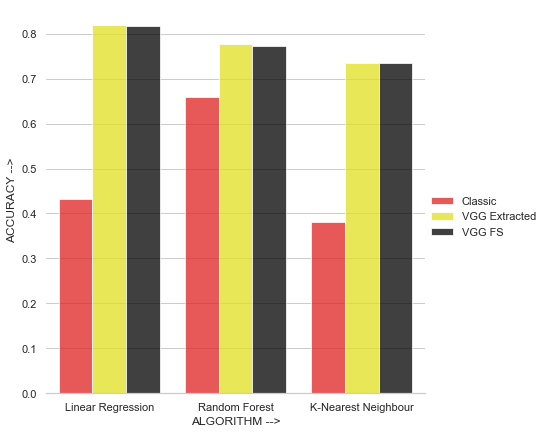

In [60]:
#Barchart for accuracy comparison
sns.set_theme(style="whitegrid")
g = sns.catplot(data = plt_data, kind='bar',x = 'Algorithm', y = 'Accuracy', hue='Type',ci="sd", palette=["red",'yellow','black'], alpha=.75, height=6)
g.despine(left=True)
g.set_axis_labels("ALGORITHM -->", "ACCURACY -->")
g.legend.set_title("")

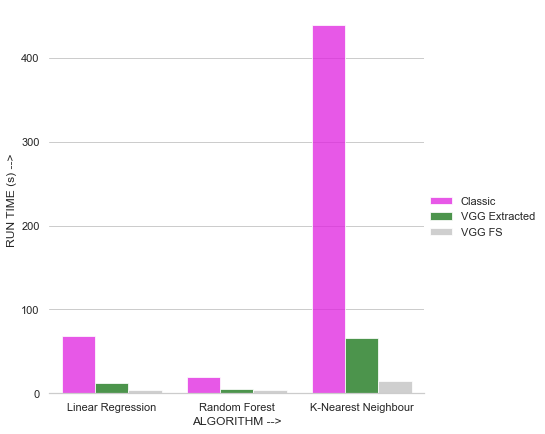

In [59]:
#Bar Chart for runtime comparison
sns.set_theme(style="whitegrid")
g = sns.catplot(data = plt_data, kind='bar',x = 'Algorithm', y = 'Run_Time', hue='Type',ci="sd", palette=["magenta",'green','silver'], alpha=.75, height=6,)
g.despine(left=True)
g.set_axis_labels("ALGORITHM -->", "RUN TIME (s) -->")
g.legend.set_title("")